## Data Science for Good: City of Los Angeles

![](https://media.giphy.com/media/3XAU2dw8fjghZmsRZd/giphy.gif)

### Problem statement

The goal is to convert a folder full of plain-text job postings into a single structured CSV file and then to use this data to:
1.  identify language that can negatively bias the pool of applicants; 
2.  improve the diversity and quality of the applicant pool; and/or 
3.  make it easier to determine which promotions are available to employees in each job class.

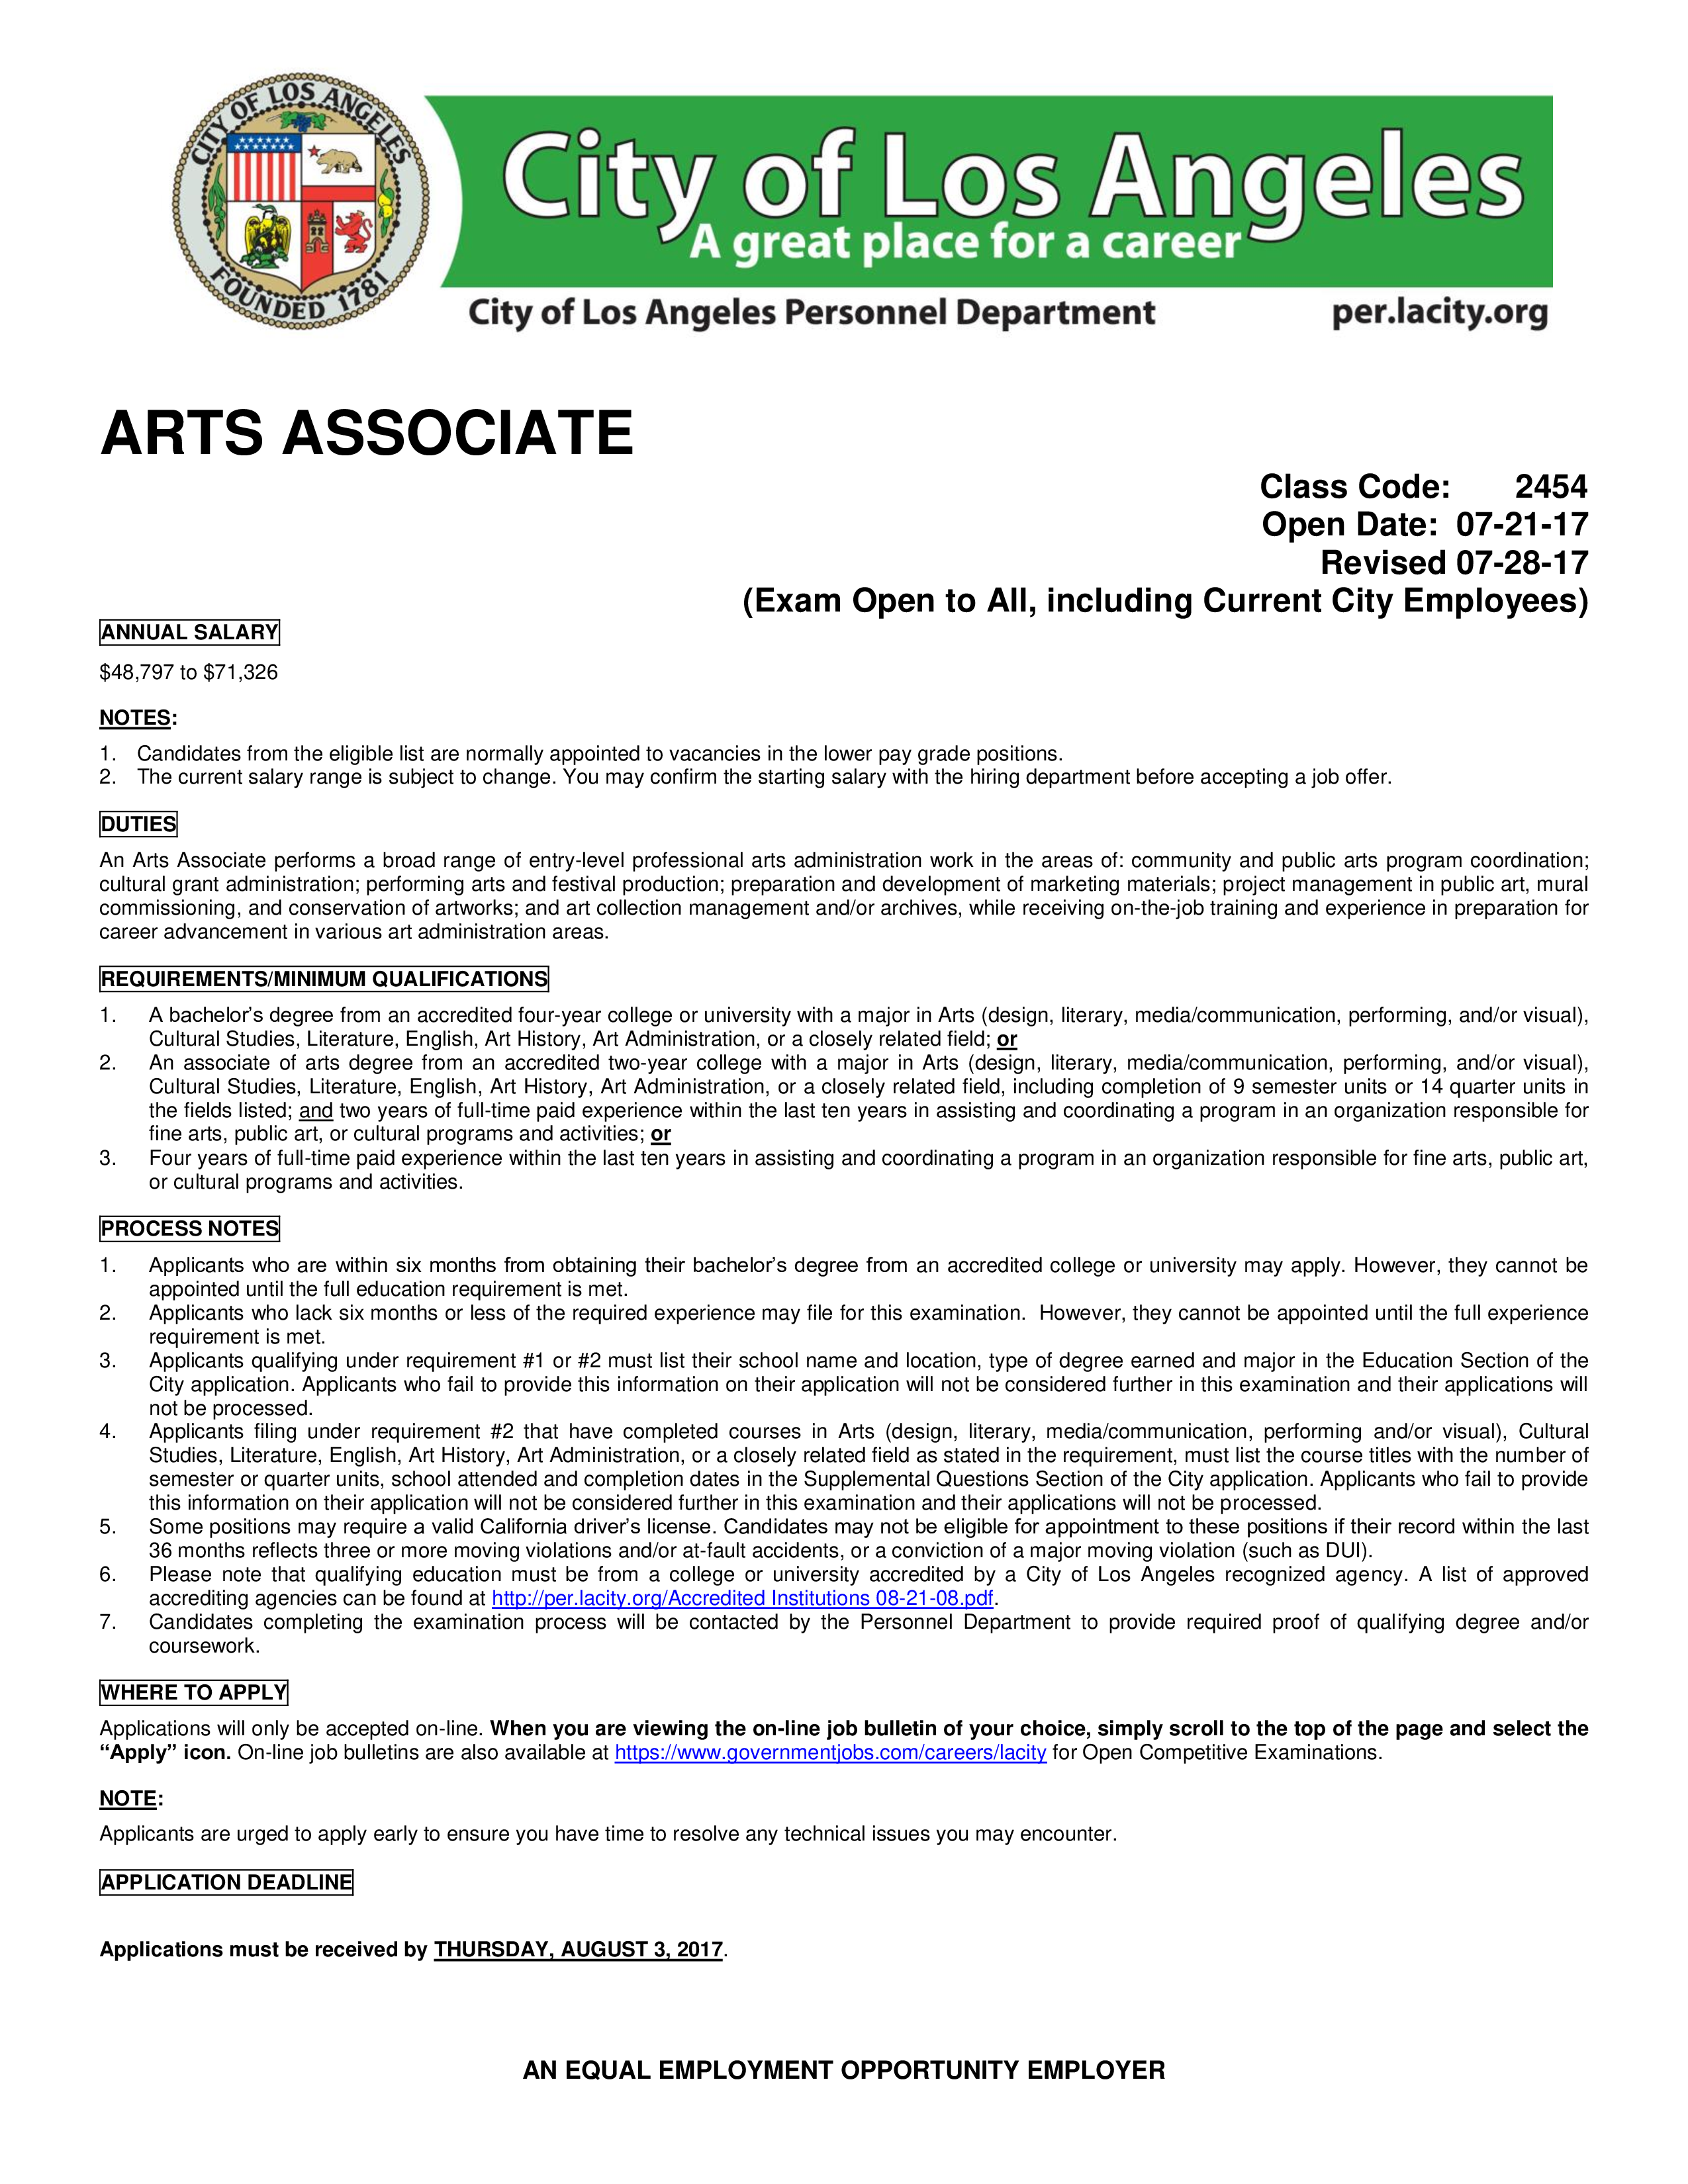

In [1]:
from wand.image import Image as Img
Img(filename='../input/cityofla/CityofLA/Additional data/PDFs/2017/july 2017/July 21/ARTS ASSOCIATE 2454 072117 REV 072817.pdf', resolution=300)

## What is in this kernel?

0. [Getting basic idea](#0)
1. [Data Preparation](#1)
2. [Exploratory data analysis](#2)
    1. [Suggestions ](#3)
3. [Finding and removing word biases](#4)
4. [Clustering jobs ](#5)
5. [Readability Index](#6)



### Importing Libraries

In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os
import numpy as np
from datetime import datetime
from collections  import Counter
from nltk import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
print(os.listdir("../input"))
from gensim.models import word2vec
from sklearn.manifold import TSNE
from nltk import pos_tag
from nltk.help import upenn_tagset
import gensim
import matplotlib.colors as mcolors
from nltk import jaccard_distance
from nltk import ngrams
#import textstat
plt.style.use('ggplot')

['cityofla']


/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


### checking all subdirectories

In [3]:
files=[dir for dir in os.walk('../input/cityofla')]
for file in files:
    print(os.listdir(file[0]))
    print("\n")

['CityofLA']


['Additional data', 'Job Bulletins']


['job bulletins with annotations', 'job_titles.csv', 'PDFs', 'Description of promotions in job bulletins.docx', 'City Job Paths', 'kaggle_data_dictionary.csv', 'sample job class export template.csv']


['Annotation elements with description.docx', 'systems_analyst.pdf', 'tree_surgeon.pdf', 'carpenter.pdf']


['2014', '2015', '2018', '2016', '2017']


['September 2014', 'May 2014', 'november 2014', 'June 2014', 'january 2014', 'october 2014', 'February 2014', 'December 2014', 'march 2014', 'April 2014', 'July 2014']


['09262014']


['Thumbs.db', 'CHIEF INSPECTOR 4254.pdf', 'PRINCIPAL INSPECTOR 4226.pdf']


['050214', '050914', '052314', '053014', '051614', '050714 rev']


['Thumbs.db', 'AQUARIST 2400.pdf', 'Job summaries 050214.pdf', 'STEAM PLANT MAINTENANCE SUPERVISOR 3786.pdf']


['Thumbs.db', 'POLICE SERGEANT 2227.pdf', 'Job summaries 05092014.pdf', 'PRINCIPAL CITY PLANNER 7946.pdf', 'SENIOR COMMERCIAL FIELD REPRESENTATIVE 1602.p

- job bulletins :This directory contains the job bulletins in text format.
- additional data :This directory contains additional data in pdf and csv format. 

In [4]:
bulletins=os.listdir("../input/cityofla/CityofLA/Job Bulletins/")
additional=os.listdir("../input/cityofla/CityofLA/Additional data/")

We will find and print all the files inside **Additional data** that has csv format.

In [5]:
csvfiles=[]
for file in additional:
    if file.endswith('.csv'):
        print(file)
        csvfiles.append("../input/cityofla/CityofLA/Additional data/"+file)
        

job_titles.csv
kaggle_data_dictionary.csv
sample job class export template.csv


There are 3 comma seperated files inside the folder,
1. job titles : contains the title given to different jobs available.
2. sample job class export template.csv : contains sample job bulletin to csv export details.
3. kaggle_data_dictionary : contains name and description of each column that is in sample job class export template.

### Reading the required csv files

In [6]:
job_title=pd.read_csv(csvfiles[0])
sample_job=pd.read_csv(csvfiles[1])
kaggle_data=pd.read_csv(csvfiles[2])

## Getting  basic ideas[^](#0)<a id="0"></a><br>

In the below section we will take a look at the three csv files which was just loaded to get basic understanding of the data.

In [7]:
job_title.head()

,311 DIRECTOR
0,ACCOUNTANT
1,ACCOUNTING CLERK
2,ACCOUNTING RECORDS SUPERVISOR
3,ADMINISTRATIVE ANALYST
4,ADMINISTRATIVE CLERK


In [8]:
print("The are %d rows and %d cols in job_title file" %(job_title.shape))

The are 667 rows and 1 cols in job_title file


In [9]:
    sample_job[sample_job['Field Name']=='SCHOOL_TYPE']['Description']

7    School Type: School type required (e.g. colleg...
Name: Description, dtype: object

In [10]:
print("The are %d rows and %d cols in sample_job file" %(sample_job.shape))


The are 25 rows and 7 cols in sample_job file


In [11]:
kaggle_data.head()

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"the development, analysis, implementation or m...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"performing cost benefit, feasibility and requi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
3,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,C,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,performing system implementation and support a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
4,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,3,A,"A Systems Analyst analyzes procedures, methods...",NaN,NaN,NaN,2.0,FULL-TIME,SYSTEMS AIDE,NaN,NaN,4.0,"3M, 4Q",INFORMATION SYSTEMS|SYSTEMS ANALYSIS|closely r...,At least three of the courses must be from the...,M,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


In [12]:
print("The are %d rows and %d cols in kaggle_data file" %(kaggle_data.shape))

The are 5 rows and 25 cols in kaggle_data file


In [13]:
print("There are %d text files in bulletin directory" %len(bulletins))

There are 683 text files in bulletin directory


#### Extracting the headings from job bulletins

In [14]:
def get_headings(bulletin):       
    
    """"function to get the headings from text file
        takes a single argument
        1.takes single argument list of bulletin files"""
    
    with open("../input/cityofla/CityofLA/Job Bulletins/"+bulletins[bulletin]) as f:    ##reading text files 
        data=f.read().replace('\t','').split('\n')
        data=[head for head in data if head.isupper()]
        return data
        
def clean_text(bulletin):      
    
    
    """function to do basic data cleaning
        takes a single argument
        1.takes single argument list of bulletin files"""
                                            
    
    with open("../input/cityofla/CityofLA/Job Bulletins/"+bulletins[bulletin]) as f:
        data=f.read().replace('\t','').replace('\n','')
        return data

#### Headings

We will print headings from first two job bulletins file.

In [15]:
get_headings(1)


['HARBOR PLANNING AND ECONOMIC ANALYST',
 'REVISED: 11-29-16',
 'ANNUAL SALARY ',
 'NOTES:',
 'DUTIES',
 'REQUIREMENTS/ MINIMUM QUALIFICATIONS',
 'PROCESS NOTES',
 'WHERE TO APPLY',
 'NOTE:',
 'APPLICATION DEADLINE',
 'SELECTION PROCESS',
 'NOTES:',
 'THIS EXAMINATION IS TO BE GIVEN BOTH ON AN',
 'INTERDEPARTMENTAL PROMOTIONAL AND AN OPEN COMPETITIVE BASIS',
 'AN EQUAL EMPLOYMENT OPPORTUNITY EMPLOYER']

In [16]:
get_headings(2)

['MANAGING WATER UTILITY ENGINEER',
 'REVISED: 04-04-17',
 'ANNUAL SALARY   ',
 'NOTES:',
 'DUTIES',
 'REQUIREMENTS/MINIMUM QUALIFICATIONS',
 'PROCESS NOTES',
 'WHERE TO APPLY',
 'NOTE:',
 'APPLICATION DEADLINE',
 'SELECTION PROCESS',
 'NOTES:',
 'THIS EXAMINATION IS TO BE GIVEN ONLY',
 ' ON AN INTERDEPARTMENTAL PROMOTIONAL BASIS',
 'AN EQUAL EMPLOYMENT OPPORTUNITY EMPLOYER']

- we can observe that there is some specefic pattern or format which is kept while writing job bulletins.
- The order of the headings almost coincides with each other,which will be beneficial for our task.

## Data preparation[^](#1)<a id="1" ></a><br>

In [17]:



def to_dataframe(num,df):
    """"function to extract features from job bulletin text files and convert to
    pandas dataframe.
    function take two arguments 
                        1.the number of files to be read
                        2.dataframe object                                      """
    

    
    opendate=re.compile(r'(Open [D,d]ate:)(\s+)(\d\d-\d\d-\d\d)')       #match open date
    
    salary=re.compile(r'\$(\d+,\d+)((\s(to|and)\s)(\$\d+,\d+))?')       #match salary
    
    requirements=re.compile(r'(REQUIREMENTS?/\s?MINIMUM QUALIFICATIONS?)(.*)(PROCESS NOTE)')      #match requirements
    
    for no in range(0,num):
        with open("../input/cityofla/CityofLA/Job Bulletins/"+bulletins[no],encoding="ISO-8859-1") as f:         #reading files 
                try:
                    file=f.read().replace('\t','')
                    data=file.replace('\n','')
                    headings=[heading for heading in file.split('\n') if heading.isupper()]             ##getting heading from job bulletin

                    sal=re.search(salary,data)
                    date=datetime.strptime(re.search(opendate,data).group(3),'%m-%d-%y')
                    try:
                        req=re.search(requirements,data).group(2)
                    except Exception as e:
                        req=re.search('(.*)NOTES?',re.findall(r'(REQUIREMENTS?)(.*)(NOTES?)',
                                                              data)[0][1][:1200]).group(1)
                    
                    duties=re.search(r'(DUTIES)(.*)(REQ[A-Z])',data).group(2)
                    try:
                        enddate=re.search(
                                r'(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2},\s\d{4})'
                                ,data).group()
                    except Exception as e:
                        enddate=np.nan
                    
                    selection= [z[0] for z in re.findall('([A-Z][a-z]+)((\s\.\s)+)',data)]     ##match selection criteria
                    
                    df=df.append({'File Name':bulletins[no],'Position':headings[0].lower(),'salary_start':sal.group(1),
                               'salary_end':sal.group(5),"opendate":date,"requirements":req,'duties':duties,
                                'deadline':enddate,'selection':selection},ignore_index=True)
                    
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)\s(years?)\s(of\sfull(-|\s)time)')
                    df['EXPERIENCE_LENGTH']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['FULL_TIME_PART_TIME']=df['EXPERIENCE_LENGTH'].apply(lambda x:  'FULL_TIME' if x is not np.nan else np.nan )
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)(\s|-)(years?)\s(college)')
                    df['EDUCATION_YEARS']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['SCHOOL_TYPE']=df['EDUCATION_YEARS'].apply(lambda x : 'College or University' if x is not np.nan else np.nan)
                    
                except Exception as e:
                    print('umatched sequence')
                    
                    
                
                
        
           
    return df

            
            
            
            

In [18]:
df=pd.DataFrame(columns=['File Name','Position','salary_start','salary_end','opendate','requirements','duties','deadline'])
df=to_dataframe(len(bulletins),df)
df.to_csv('job class output.csv')

umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence
umatched sequence


In [19]:
df.shape

(660, 13)

In [20]:
df.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,selection,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,water service representative,"70,177","$87,194",2017-11-17,Three years of full-time paid experience in a ...,A Water Service Representative makes field inv...,"NOVEMBER 30, 2017",[Test],Three,FULL_TIME,NaN,NaN
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,harbor planning and economic analyst,"70,908","$103,648",2016-11-18,1. Graduation from an accredited four-year col...,A Harbor Planning and Economic Analyst perform...,"DECEMBER 8, 2016",[Questionnaire],Two,FULL_TIME,four,College or University
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,managing water utility engineer,"148,561","$184,579",2017-03-24,1. Two years of full-time paid experience at t...,A Managing Water Utility Engineer may serve as...,"APRIL 13, 2017","[Essay, Interview]",Two,FULL_TIME,NaN,NaN
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,veterinary technician,"50,425","$73,706",1999-02-05,A Registered Veterinary Technician (RVT) certi...,A Veterinary Technician assists a Veterinarian...,NaN,[Review],NaN,NaN,NaN,NaN
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,senior utility services specialist,"117,199","$145,596",2018-11-30,Two years of full-time paid experience with th...,"A Senior Utility Services Specialist assigns, ...","DECEMBER 13, 2018","[Essay, Interview]",Two,FULL_TIME,NaN,NaN


### Preparing the data dictionary

In [21]:
data_dictionary=pd.DataFrame({'Field Name':['File Name','Position','salary_start','salary_end','opendate',
                                            'requirements','duties','deadline','selection','EXPERIENCE_LENGTH','FULL_TIME_PART_TIME','EDUCATION_YEARS','SCHOOL_TYPE'],
                             })

data_dictionary['Description']=['The file name of the job bulletin from which each record came','The title of the particular class (e.g., Systems Analyst, Carpenter)',
                              'The overall salary start','The overall maximum salary','The date the job bulletin opened','Overall requirement that has to be filled',
                              'A summary of what someone does in the particular job\n','The date the job bulletin closed','list of selection criterias','Years required in a particular job class or external role.',
                              'Whether the required experience is full-time, part','Years required in a particular education program',
                               'School Type: School type required (e.g. college or university, high school)']

data_dictionary['Data Type']=['string']*13

data_dictionary['Accepts Null Values?']=['Yes']*13

In [22]:
data_dictionary

,Field Name,Description,Data Type,Accepts Null Values?
0,File Name,The file name of the job bulletin from which e...,string,Yes
1,Position,"The title of the particular class (e.g., Syste...",string,Yes
2,salary_start,The overall salary start,string,Yes
3,salary_end,The overall maximum salary,string,Yes
4,opendate,The date the job bulletin opened,string,Yes
5,requirements,Overall requirement that has to be filled,string,Yes
6,duties,A summary of what someone does in the particul...,string,Yes
7,deadline,The date the job bulletin closed,string,Yes
8,selection,list of selection criterias,string,Yes
9,EXPERIENCE_LENGTH,Years required in a particular job class or ex...,string,Yes


In [23]:
data_dictionary.to_csv('data dictionary.csv')

 Now we have a proper comma seperataed file containing most of the information we need.we will now start exploring it. 

Here,
- **Position** implies JOB_CLASS_TITLE
- **Duties** implies JOB_DUTIES
- **Requirements** : All of the job requirements posted under requirements section
- **Salary** has been broken down to **Salary_start** and **Salary_end** which signifies the salary range.
    for example $ 5000 to $ 6000 
        salary_start = 5000
        salary_end = 6000
- **Opendate** : The job application open date
- **deadline** : deadline for applying for the job.
- **selection** : The list of  selection criterias.

## Exploratory data analysis[^](#2)<a id="2"></a><br>

### which are the common job sectors in LA?

In [24]:
print('There are %d different jobs available' %df['Position'].nunique())

There are 650 different jobs available


Text(0, 0.5, 'sector')

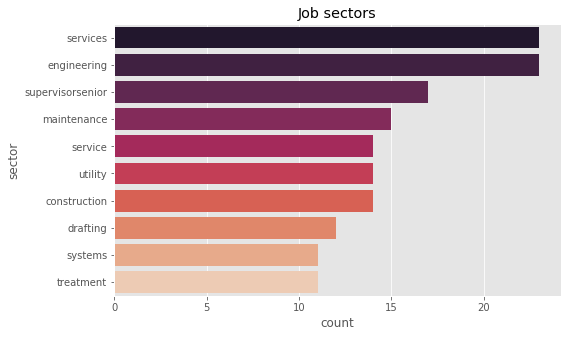

In [25]:
plt.figure(figsize=(8,5))
text=''.join(job for job in df['Position'])                                ##joining  data to form text
text=word_tokenize(text)
jobs=Counter(text)                                                         ##counting number of occurences
jobs_class=[job for job in jobs.most_common(12) if len(job[0])>3]          ##selecting most common words
#offers=[job[1] for job in jobs.most_common(12) if len(job[0]>3)]
a,b=map(list, zip(*jobs_class))
sns.barplot(b,a,palette='rocket')                                           ##creating barplot
plt.title('Job sectors')
plt.xlabel("count")
plt.ylabel('sector')


- We can see that **service sector** dominates in creating opputunities.

- It might be a good idea to have **different display boards** for service and product sectors,so that candidates can easily find job of their preference.

In [26]:
""""
    convert salary to proper  form 
    by removing '$' and ',' symbols.
                                    """

df['salary_start']=[int(sal.split(',')[0]+sal.split(',')[1] ) for sal in df['salary_start']]   
df['salary_end']=[sal.replace('$','')  if sal!= None else 0 for sal in df['salary_end']  ]
df['salary_end']=[int(sal.split(',')[0]+sal.split(',')[1] ) if type(sal)!=int else 0 for sal in df['salary_end']]

### What about the salary distribution?

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


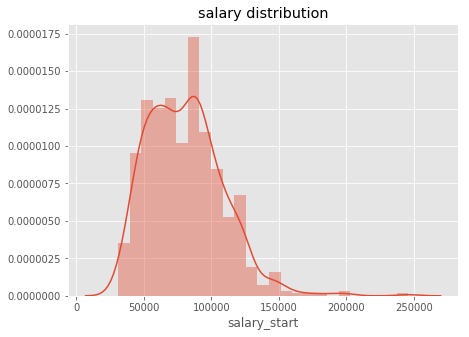

In [27]:
plt.figure(figsize=(7,5))
sns.distplot(df['salary_start'])
plt.title('salary distribution')
plt.show()

- we can observe that thet salaries typically varies from $50k to $150k.
- Most jobs salary start from $80000.

### Which are the best paid jobs in LA?

Text(0.5, 1.0, 'Best paid jobs in LA')

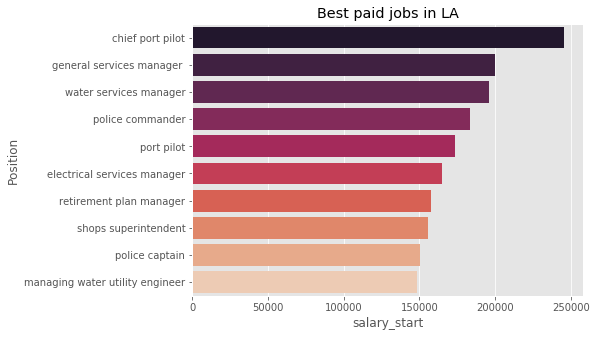

In [28]:
'''finding the most paid 10 jobs at LA'''

most_paid=df[['Position','salary_start']].sort_values(by='salary_start',ascending=False)[:10]
plt.figure(figsize=(7,5))
sns.barplot(y=most_paid['Position'],x=most_paid['salary_start'],palette='rocket')
plt.title('Best paid jobs in LA')

### Which the jobs with highest salary deviation?

In [29]:
''''calculating salary start - salary end '''

df['salary_diff']=abs(df['salary_start']-df['salary_end'])

ranges=df[['Position','salary_diff']].sort_values(by='salary_diff',ascending=False)[:10]

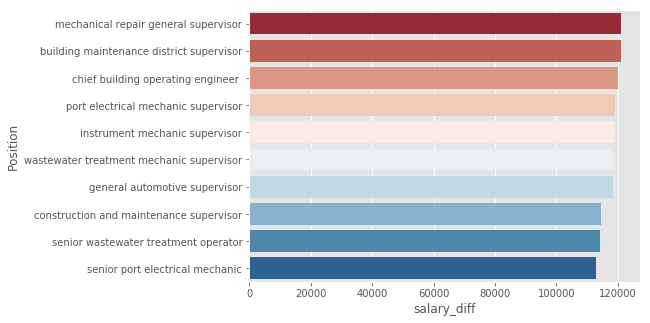

In [30]:
plt.figure(figsize=(7,5))
sns.barplot(y=ranges['Position'],x=ranges['salary_diff'],palette='RdBu')   ##plotting



In [31]:
ranges

,Position,salary_diff
597,mechanical repair general supervisor,121166
129,building maintenance district supervisor,121166
599,chief building operating engineer,119997
300,port electrical mechanic supervisor,119172
71,instrument mechanic supervisor,119036
430,wastewater treatment mechanic supervisor,118843
496,general automotive supervisor,118577
312,construction and maintenance supervisor,114485
589,senior wastewater treatment operator,114234
137,senior port electrical mechanic,112955


### Has job opportunities really increased recently?

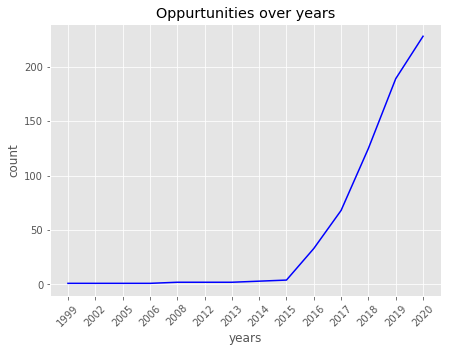

In [32]:
'''Extracting year out of opendate timestamp object and counting
    the number of each occurence of each year using count_values() '''

df['year_of_open']=[date.year for date in df['opendate']]

count=df['year_of_open'].value_counts(ascending=True)
years=['2020','2019','2018', '2017', '2016', '2015', '2014', '2013', '2012', '2008', '2006',
           '2005', '2002', '1999']
plt.figure(figsize=(7,5))
plt.plot([z for z in reversed(years)],count.values,color='blue')

plt.title('Oppurtunities over years')
plt.xlabel('years')
plt.ylabel('count')
plt.gca().set_xticklabels([z for z in reversed(years)],rotation='45')
plt.show()

- It is evident from the above graph that job oppurtunities is constantly increasing after 2012 or so. 
- job oppurtunities has never decreased.

### What about the full time experience?

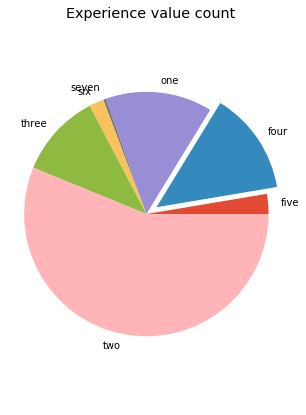

In [33]:
experience=df['EXPERIENCE_LENGTH'].value_counts().reset_index()
experience['index']=experience['index'].apply(lambda x : x.lower())
experience=experience.groupby('index',as_index=False).agg('sum')
labels=experience['index']
sizes=experience['EXPERIENCE_LENGTH']
plt.figure(figsize=(5,7))
plt.pie(sizes,explode=(0, 0.1, 0, 0,0,0,0),labels=labels)
plt.gca().axis('equal')
plt.title('Experience value count')
plt.show()

- I think it is clear that 50 percent of the job requires atleat two years experience in the field.
- This has a negative effect of keeping freshers away from entering the job sector.

### Experience or College degree, which is more preferred ?

<BarContainer object of 2 artists>

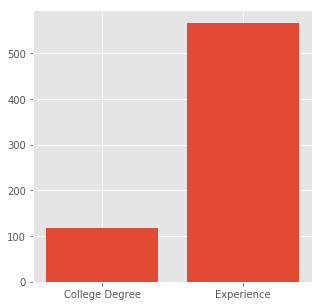

In [34]:
x1=df['SCHOOL_TYPE'].value_counts()[0]
x2=df['FULL_TIME_PART_TIME'].value_counts()[0]
plt.figure(figsize=(5,5))
plt.bar(height=[x1,x2],x=['College Degree','Experience'])


- Almost all jobs bulletins specify the experience needed by candidate to qualify for the job.
  But only some post the required educational baground.This might be in the assumption that an experienced candidate will surely posses College or university degree.

### Which month of the year offers most opportunities?

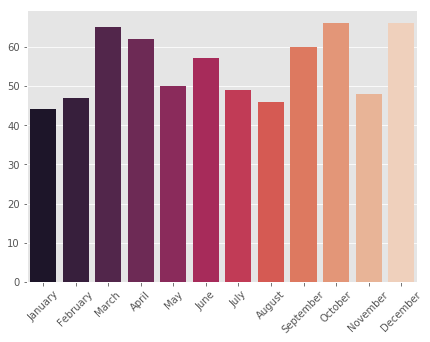

In [35]:
'''Extracting month out of opendate timestamp object and counting
    the number of each occurence of each months using count_values() '''


plt.figure(figsize=(7,5))
df['open_month']=[z.month for z in df['opendate']]
count=df['open_month'].value_counts(sort=False)
sns.barplot(y=count.values,x=count.index,palette='rocket')
plt.gca().set_xticklabels([calendar.month_name[x] for x in count.index],rotation='45')
plt.show()

We can see that there is more job opportunities created in the months of **March,October and December**

*** - It  might be a good idea to declare these months as **hiring months** and this could even attract a lot of potential candidates.

### Which day of the week ?

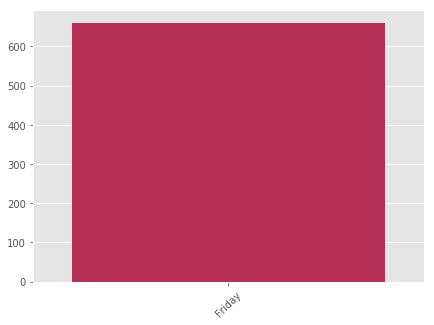

In [36]:
'''Extracting weekday out of opendate timestamp object and counting
    the number of each occurence of each weekday using count_values() '''


plt.figure(figsize=(7,5))

df['open_day']=[z.weekday() for z in df['opendate']]
count=df['open_day'].value_counts(sort=False)
sns.barplot(y=count.values,x=count.index,palette='rocket')
plt.gca().set_xticklabels([calendar.day_name[x] for x in count.index],rotation='45')
plt.show()

Wow ! All the postings are open from **friday** ! This is pretty interesting.
- Is there any specific reason behind this?
We will try to find out.
anyway its good to post all opening in a day  of week so  that candidates can refer the bulletins and apply without missing any openings.

### what about deadlines ?

In [37]:
print('%d job applications may close without prior notice' %df['deadline'].isna().sum())


44 job applications may close without prior notice


- I think employers should post a deadline for job application in the job bulletins to avoid any unwanted confusions between candidates.

In [38]:
#df['dealine']=df['deadline'].fillna(method='backfill',inplace=True
#deadline=[datetime.strptime(x,'%B %d, %Y')  for x in df['deadline'] ]


In [39]:
req=' '.join(text for text in df['requirements'])


### Word Cloud of Requirements

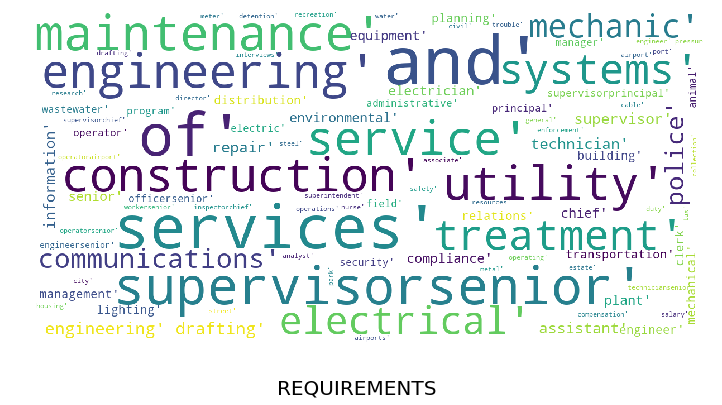

In [40]:

def show_wordcloud(data, title = None):
    
    
    '''funtion to produce and display wordcloud
        taken 2 arguments
        1.data to produce wordcloud
        2.title of wordcloud'''
    
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=250,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(text,'REQUIREMENTS')

### Most influential words in requirements

In [41]:
lem=WordNetLemmatizer()
text=[lem.lemmatize(w) for w in word_tokenize(req)]
vect=TfidfVectorizer(ngram_range=(1,3),max_features=100)
vectorized_data=vect.fit_transform(text)
#id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vect.vocabulary_.keys()

dict_keys(['three', 'year', 'of', 'full', 'time', 'full time', 'paid', 'experience', 'in', 'class', 'at', 'the', 'level', 'service', 'performing', 'public', 'work', 'water', 'related', 'and', 'from', 'or', 'to', 'an', 'accredited', 'college', 'university', 'may', 'be', 'substituted', 'on', 'for', 'two', 'required', 'one', 'is', 'semester', 'quarter', 'unit', 'graduation', 'four', 'four year', 'and2', 'professional', 'planning', 'analysis', 'engineer', 'system', 'department', 'engineering', 'design', 'construction', 'operation', 'maintenance', 'with', 'california', 'certificate', 'by', 'state', 'city', 'los', 'angeles', 'position', 'that', 'which', 'provides', 'building', 'management', 'and or', 'program', 'completion', 'recognized', 'must', 'or2', 'six', 'degree', 'including', 'following', 'or3', 'month', 'valid', 'supervisor', 'least', 'course', 'senior', 'environmental', 'mechanical', 'repair', 'equipment', 'administration', 'school', 'requirement', 'supervising', 'training', 'field'

### Word 2 Vec

In [42]:
def build_corpus(df,col):
    
    '''function to build corpus from dataframe'''
    lem=WordNetLemmatizer()
    corpus= []
    for x in df[col]:
        
        
        words=word_tokenize(x)
        corpus.append([lem.lemmatize(w) for w in words])
    return corpus


In [43]:
corpus=build_corpus(df,'requirements')
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=30, workers=4)


### TSNE

In [44]:
def tsne_plot(model,title='None'):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=80, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12)) 
    plt.title(title)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


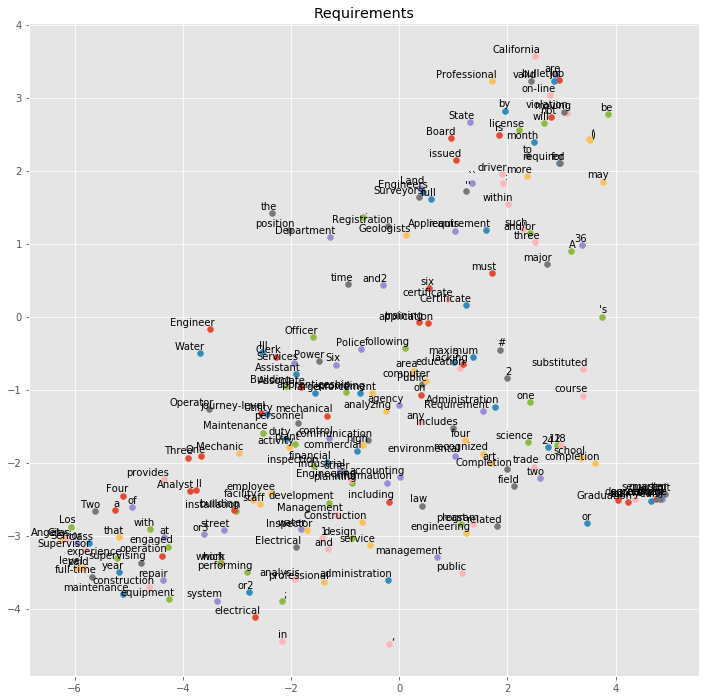

In [45]:
tsne_plot(model,'Requirements')

- we can see clusters of words used in **Requirement** section.

### What are the common requirements for any post?

In [46]:
token=word_tokenize(req)
counter=Counter(token)
count=[x[0] for x in counter.most_common(40) if len(x[0])>3]
print("Most common words in Requirement")
print(count)

Most common words in Requirement
['experience', 'paid', 'full-time', 'years', 'with', 'City', 'Angeles', 'level', 'from', 'year', 'college', 'accredited', 'university', 'class', 'professional', 'maintenance', 'which', 'units']


- It can be observed that companies prefer  
- **experienced** 
- **educated professionals**  having **degree from an accredicted university**
- also willing to work **full-time**

- To improve the diversity employers are encourged to give chance to **Freshers** and people willing to work **part time**.
     This can attract greater pool of applicants.

### Duties

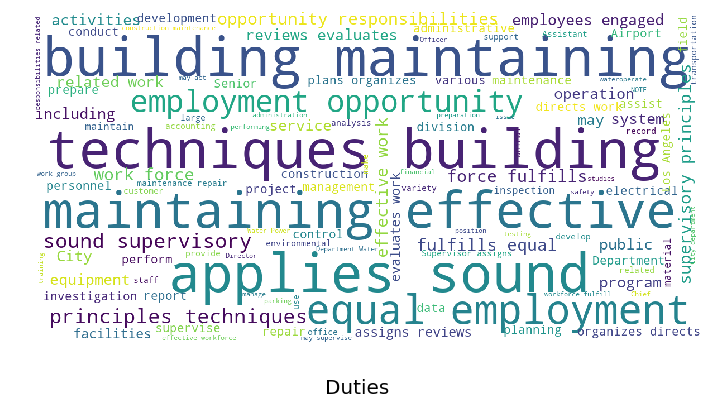

In [47]:
duties= ' '.join(d for d in df['duties'])
show_wordcloud(duties,'Duties')

### Most influential and common words in duties

In [48]:
lem=WordNetLemmatizer()
text=[lem.lemmatize(w) for w in word_tokenize(duties)]
vect=TfidfVectorizer(ngram_range=(1,3),max_features=200)
vectorized_data=vect.fit_transform(text)
#id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vect.vocabulary_.keys()

dict_keys(['water', 'service', 'make', 'field', 'investigation', 'to', 'and', 'with', 'customer', 'or', 'their', 'in', 'the', 'office', 'on', 'issue', 'for', 'planning', 'performs', 'administrative', 'technical', 'work', 'maintaining', 'port', 'plan', 'city', 'prepares', 'development', 'other', 'evaluates', 'process', 'conduct', 'transportation', 'related', 'research', 'facility', 'engineer', 'may', 'director', 'assistant', 'of', 'division', 'manager', 'major', 'project', 'system', 'department', 'power', 'an', 'general', 'senior', 'difficult', 'responsible', 'professional', 'engineering', 'preparation', 'design', 'specification', 'contract', 'study', 'treatment', 'report', 'procedure', 'various', 'distribution', 'operation', 'maintenance', 'activity', 'including', 'compliance', 'safety', 'program', 'develops', 'policy', 'applies', 'sound', 'management', 'supervisory', 'principle', 'technique', 'building', 'effective', 'workforce', 'fulfills', 'equal', 'employment', 'opportunity', 'resp

In [49]:
token=word_tokenize(duties)
counter=Counter(token)
count=[x[0] for x in counter.most_common(40) if len(x[0])>3]
print("Most common words in Duties")
print(count)

Most common words in Duties
['work', 'maintaining', 'building', 'techniques', 'applies', 'supervisory', 'sound', 'effective', 'principles', 'responsibilities', 'fulfills', 'employment', 'equal', 'opportunity', 'engaged', 'force', 'related', 'City', 'equipment', 'performs', 'plans', 'other', 'with', 'maintenance', 'employees']


### Word 2 Vec

In [50]:
corpus=build_corpus(df,'duties')
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=40, workers=4)


### TSNE

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


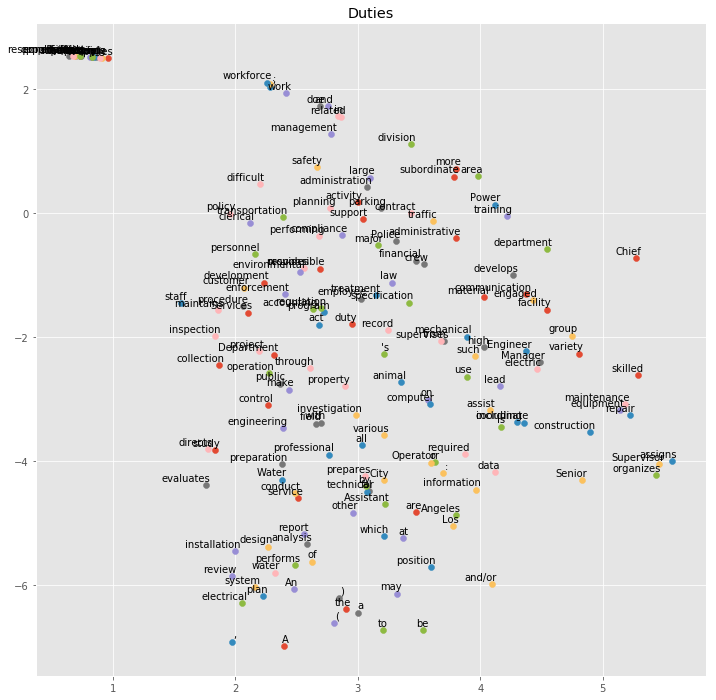

In [51]:
tsne_plot(model,'Duties')

###  Latent Dirichlet Allocation (LDA)

Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [52]:
lem=WordNetLemmatizer()
text=[lem.lemmatize(w) for w in word_tokenize(duties)]
vect=TfidfVectorizer(ngram_range=(1,3),max_features=200)
vectorized_data=vect.fit_transform(text)
id2word=dict((v,k) for k,v in vect.vocabulary_.items())



In [53]:
corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(corpus,id2word=id2word,num_topics=8,random_state=34,passes=25,per_word_topics=True)


In [54]:
ldamodel.show_topic(1)

[('effective', 0.12067284),
 ('fulfills', 0.11013252),
 ('force', 0.10859098),
 ('may', 0.09671624),
 ('service', 0.07336614),
 ('construction', 0.063684076),
 ('on', 0.05250584),
 ('operation', 0.04581603),
 ('organizes', 0.03681271),
 ('technical', 0.034591477)]

###  What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [55]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=build_corpus(df,'duties'))

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.dropna(inplace=True)
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"sound, maintenance, program, other, inspection...","[A, Water, Service, Representative, make, fiel..."
1,1,4.0,0.5625,"work, building, maintaining, opportunity, wate...","[A, Harbor, Planning, and, Economic, Analyst, ..."
2,2,1.0,0.5625,"effective, fulfills, force, may, service, cons...","[A, Managing, Water, Utility, Engineer, may, s..."
3,3,0.0,0.1250,"sound, maintenance, program, other, inspection...","[A, Veterinary, Technician, assist, a, Veterin..."
4,4,0.0,0.5625,"sound, maintenance, program, other, inspection...","[A, Senior, Utility, Services, Specialist, ass..."


### Topic modeling visualization

In [56]:
data=build_corpus(df,'duties')

### Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

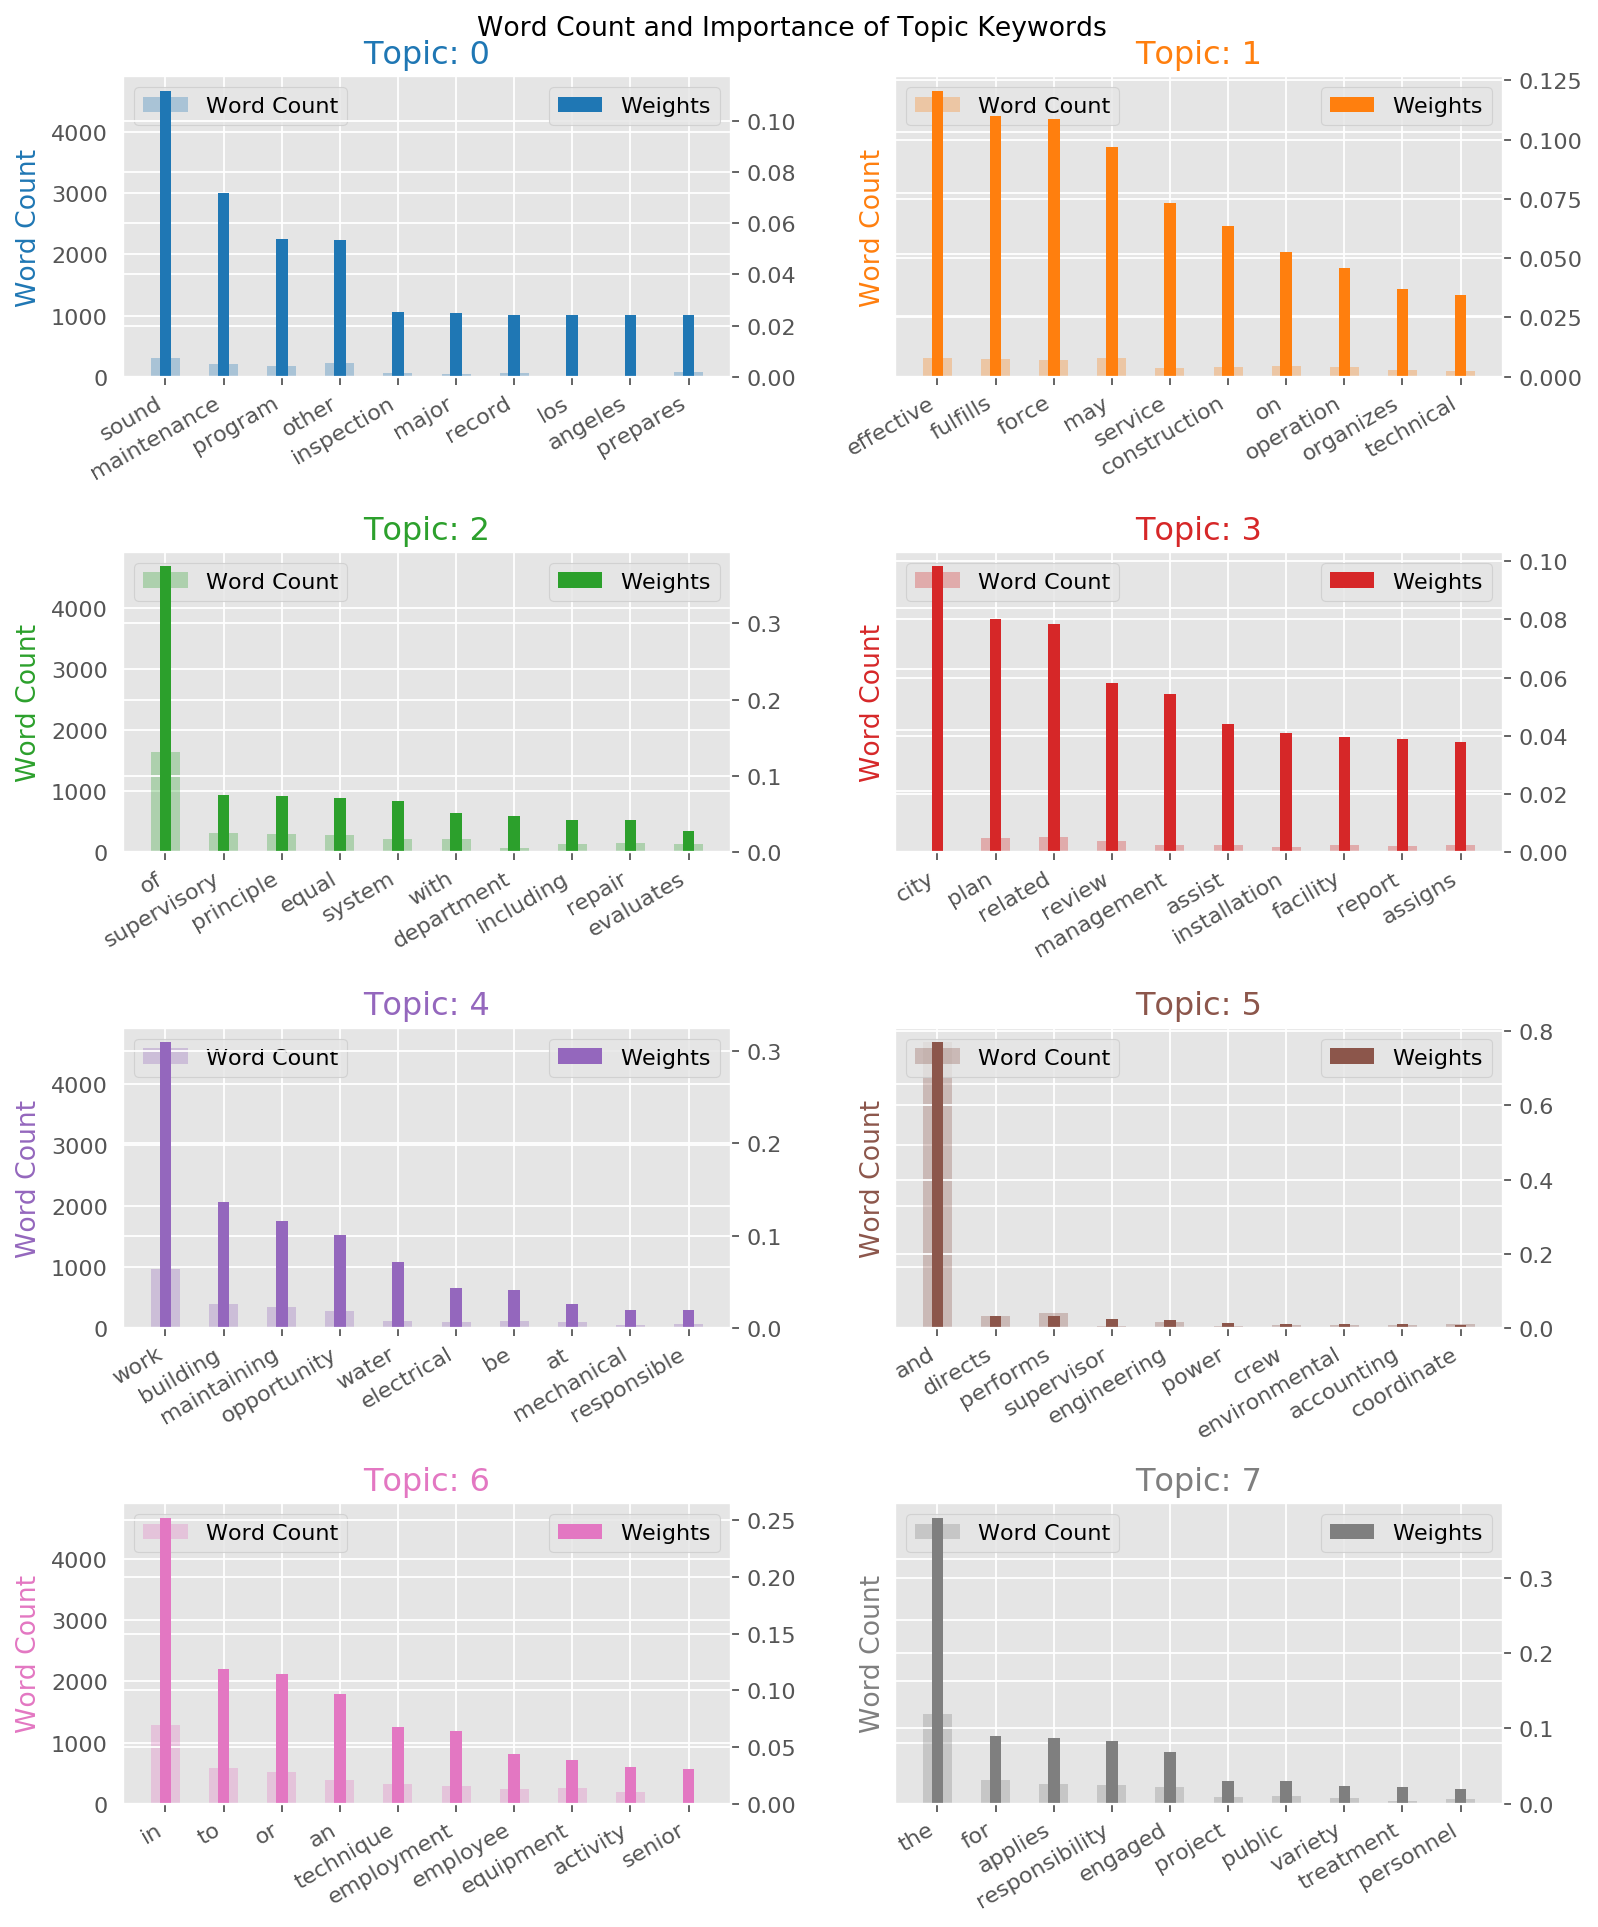

In [57]:
topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in build_corpus(df,'duties') for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_plot= pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(10,12), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_plot.loc[df_plot.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_plot.loc[df_plot.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.040); ax.set_ylim(0, 4000)
    ax.set_title('Topic: ' + str(i), color=cols[i])
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_plot.loc[df_plot.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords',y=1)    
plt.show()

### What are the most common selection criterias?

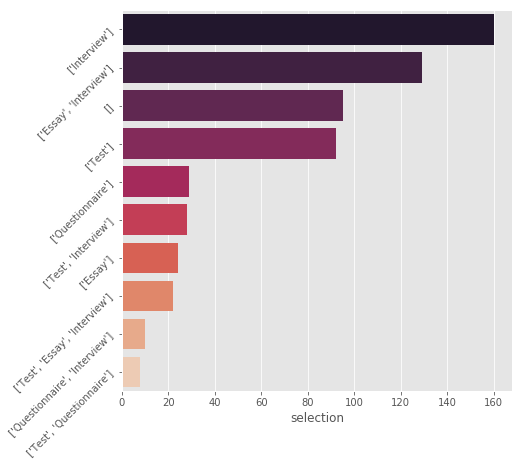

In [58]:

plt.figure(figsize=(7,7))
count=df['selection'].astype(str).value_counts()[:10]
sns.barplot(y=count.index,x=count,palette='rocket')
plt.gca().set_yticklabels(count.index,rotation='45')
plt.show()


- It is evident that  **interview** ,**Essay** and **Questionnaire** are the most common selection criterias.

### Suggestions[](#3)<a id='3'></a><br>

1. It might be a good idea to have **different display boards** for service and product sectors,so that candidates can easily find job of their preference.
2. 50 percent of the job requires atleat two years experience in the field.This has a negative effect of keeping freshers away from entering the job sector.
3. It  might be a good idea to declare March,October,December months as **hiring months** and this could even attract a lot of potential candidates.
4. Define a deadline to avoid confusions and delaying.(2weeks is ideal)


## Finding and removing gender biases[^](#4)<a id="3"></a><br>

### Is there any Gender bias in job bulletins?

In the follow section i am trying investigate if there is any gender biased terms used in **Requirement** and **Duties** section of the job bulletin.   
For that i will pos tag all the text data in the requirement field and then,
- Extract the words having pronoun tag.
- check if any gender biased terms like he/she is used in the field.


In [59]:
def pronoun(data):
    
    '''function to tokenize data and perform pos_tagging.Returns tokens having "PRP" tag'''
    
    prn=[]
    vrb=[]
    token=word_tokenize(data)
    pos=pos_tag(token)
   
    vrb=Counter([x[0] for x in pos if x[1]=='PRP'])
    
    return vrb
    


req_prn=pronoun(req)
duties_prn=pronoun(duties)
print('pronouns used in requirement section are')
print(req_prn.keys())
print('\npronouns used in duties section are')
print(duties_prn.keys())


pronouns used in requirement section are
dict_keys(['or2', 'or3', 'orb', 'I', 'orB', 'or4', 'or5', 'or6', 'you', 'they', 'orc', 'ore.', 'offset', 'or7', 'or8', 'You', 'it'])

pronouns used in duties section are
dict_keys(['I', 'or2', 'they', 's', 'You', 'you', 'They', 'it'])


1. Surprisingly, i couldn't find any gender biased or racist pronouns in **Requirement ** or **Duties section**
2. you can see all the pronouns used are neutral.

###  Is there any gender bias in job titles?

- In this section we will try and find out if there is any gender bias in job titles.
    A **gender-specific job title** is a name of a job that also specifies or implies the gender of the person performing that job. 
    the job title **policeman** implies that the person is male. A gender-neutral job title, on the other hand, is one that does not specify or imply       gender, such as firefighter or a lawyer.

In [60]:
names=['senior waterman','policeman']
for name in names:
    z=re.match(r'\w+?\s?\w+(man|women)$',name)
    print(z)

<_sre.SRE_Match object; span=(0, 15), match='senior waterman'>
<_sre.SRE_Match object; span=(0, 9), match='policeman'>


- So you can see that the code works well.We will try in our dataset.

In [61]:
for name in df['Position']:
    z=re.match(r'\w+?\s?\w+(man|women)$',name)
    if z is not None:
        print(z)
    

- Nothing ! I think the authorities hava done a good job by removing possible gender biases from job titles and renamed it suitably.

## Clustering Jobs [^](#5)<a id="4"></a><br>

### Finding similar jobs

Here in this section I am trying to find similar jobs given a job title.
- **Assumption** : I assume that similar jobs have similar job title.    
               
I have used jaccard distance to find the text similarity and compare it with a threashold value to obtain the jobs.     
This method can output the jobs the same domain so that candidates who posses the right skills can apply for similar jobs in the domain.I believe clustering jobs can improve the pool of applicants to great extend.


In [62]:

def similar_jobs(job):
    
    ''' function to find and return jobs with similar job title.take a single argument
            - job title
            returns
                -list of similar jobs '''
    
    word1=word_tokenize(job)
    jobs=[]
    for i,name in enumerate(df['Position']):
        word2=word_tokenize(name)
        distance=jaccard_distance(set(ngrams(word1,n=1)),set(ngrams(word2,n=1)))
        if(distance<.55):
            jobs.append((name,i))
    return jobs

In [63]:
similar_jobs(df['Position'][10])

[('construction and maintenance superintendent', 10),
 ('maintenance and construction helper', 118),
 ('construction and maintenance supervisor', 312),
 ('building construction and maintenance', 433),
 ('street lighting construction and maintenance superintendent', 586)]

- you can clearly observe that the jobs outputted are from the same domain and are moreover similar.

### Finding jobs with similar requirements

In [64]:
def similar_req(job):
    
    ''' function to find and return jobs with similar job title.take a single argument
            - job title
            returns
                -list of similar jobs '''
    
    word1=word_tokenize(job)
    jobs=[]
    for i,name in enumerate(df['requirements']):
        word2=word_tokenize(name)
        distance=jaccard_distance(set(ngrams(word1,n=1)),set(ngrams(word2,n=1)))
        if(distance<.5):
            jobs.append((name,df.iloc[i]['Position']))
    return jobs

In [65]:
similar_req(df['requirements'][10])

[('Three years of full-time paid experience with the City of Los Angeles as a Construction and Maintenance Supervisor or in a class at that level as a second-level full-time supervisor of journey-level workers in general construction or maintenance work.',
  'construction and maintenance superintendent'),
 ('Four years of full-time paid experience with the City of Los Angeles as a Building Repairer or in a class at that level which provides experience in building maintenance and repair work.',
  'building repair supervisor'),
 ('Two years of full-time paid experience with the City of Los Angeles as an Automotive Supervisor or in a class at that level supervising employees engaged in the maintenance and repair of transportation or construction equipment.',
  'senior automotive supervisor')]

In [66]:
df['requirements'][312]

'1. Two years of full-time paid experience in a class at the level of Carpenter Supervisor supervising a crew doing construction work; or2. Three years of full-time paid experience as a Labor Supervisor with the City of Los Angeles; or3. Three years of full-time paid experience in a class at the level of Mechanical Repair Supervisor supervising a crew installing and repairing equipment as part of construction work.'

- City of LA can use any of the similarity functions available to find jobs having similar requirements,for example jaccard distace,cosine similary etc..I have implemented jaccard similarity the in above section.

## Readability Index[^](#6)<a id="5"></a><br>

- FleschKincaid Grade Level       
Designed to indicate how difficult a reading passage is to understand. The result is a number that corresponds with a U.S grade level.
> FKGL = 0.39 * (total words/ total 
sentences) + 11.8 (total syllables/ 
total words) -15.59




**Flesch Index  -------         Text file reading Grade**

   0-30      ---------              College                 

   50-60     ---------               High School                          
	
   90-100    ---------                Fourth Grade

	
1. From above the flesch-kincaid Grade level formula is used to compute the equivalent Grade level G −

In [67]:
reading=[]
for file in df['File Name']:
    text=open("../input/cityofla/CityofLA/Job Bulletins/"+file,'r',encoding="ISO-8859-1").read()
    sentence = text.count('.') + text.count('!') + text.count(';') + text.count(':') + text.count('?')
    words = len(text.split())
    syllable = 0
    for word in text.split():
        for vowel in ['a','e','i','o','u']:
            syllable += word.count(vowel)
        for ending in ['es','ed','e']:
            if word.endswith(ending):
                   syllable -= 1
        if word.endswith('le'):
            syllable += 1
            
    G = round((0.39*words)/sentence+ (11.8*syllable)/words-15.59)
    reading.append(G)

- Plotting Grade level distribution

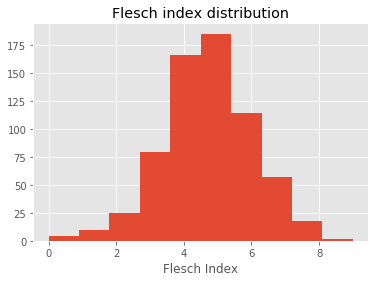

In [68]:
plt.hist(reading)
plt.xlabel('Flesch Index')
plt.title('Flesch index distribution')
plt.show()

- we can see that index is always between 0-30,which comes under college grade.May be city of LA officials should look in to this and moderate their bulletins to make it simple to read !

### If you like my kernel please consider upvoting.Thank you :)